# Wikimedia Discovery - Clickthrough and search analysis

*To run plotly visualizations locally, you must:*
    
*1. Create a [plotly](http://help.plot.ly/how-to-sign-up-to-plotly/) account.*

*2. Generate an API key.*

*3. Save this key to a string titled 'key' in a file titled 'contents.py' in the directory*

The following analysis is a report for the [Wikimedia Discovery department](https://www.mediawiki.org/wiki/Wikimedia_Discovery). The goals of the project are:

1. "What is our daily overall clickthrough rate? How does it vary between the groups?
2. Which results do people tend to try first? How does it change day-to-day?
3. What is our daily overall zero results rate? How does it vary between the groups?
4. Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.
5. Summarize your findings in an executive summary."

**This is a demo project intended for the Wikimedia data scientist job application. I am not actually applying for this job, but just running through the interview to build/demo skills. See [link](https://github.com/wikimedia-research/Discovery-Hiring-Analyst-2016) for more details.**

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
# set seed
np.random.seed(12345678)

In [3]:
# read data as gzip file
df = pd.read_csv('events_log.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

In [4]:
df['timestamp']=df['timestamp'].astype(int) #convert timestamp to int to slice
df['timestamp']=pd.to_datetime(df['timestamp'],format='%Y%m%d%H%M%S', errors='ignore') #convert to pandas datetime
df['day']=df['timestamp'].dt.day # add 'day' variable using handy .dt 
df['weekday']=df['timestamp'].dt.dayofweek # add 'dayofweek' variable using handy .dt 

From the original documentation:

| Column          | Value   | Description                                                                       |
|:----------------|:--------|:----------------------------------------------------------------------------------|
| uuid            | string  | Universally unique identifier (UUID) for backend event handling.                  |
| timestamp       | integer | The date and time (UTC) of the event, formatted as YYYYMMDDhhmmss.                |
| session_id      | string  | A unique ID identifying individual sessions.                                      |
| group           | string  | A label ("a" or "b").                                     |
| action          | string  | Identifies in which the event was created. See below.                             |
| checkin         | integer | How many seconds the page has been open for.                                      |
| page_id         | string  | A unique identifier for correlating page visits and check-ins.                    |
| n_results       | integer | Number of hits returned to the user. Only shown for searchResultPage events.      |
| result_position | integer | The position of the visited page's link on the search engine results page (SERP). |

In [5]:
df=df.sort_values(by=['session_id','timestamp'])

In [6]:
# get acclimated...
df.head(3)
# df.info()
# len(df)

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,day,weekday
361077,e6f9280c8df5536490eb925a91979a3b,2016-03-03 15:20:45,0000cbcb67c19c45,b,searchResultPage,NaN,fdeeb9aaf0130d41,20.0,NaN,3,3
142278,5b394c862bf657d98bcd25589a5247ac,2016-03-07 08:49:55,0001382e027b2ea4,b,searchResultPage,NaN,7aa28c36c03380a0,18.0,NaN,7,0
317464,cae3f7c7ce5d5d28b4bd6d318d962b1b,2016-03-07 08:49:58,0001382e027b2ea4,b,visitPage,NaN,f88793c95e778898,NaN,1.0,7,0


We have {{len(df)}} total UUIDs.

In [7]:
number_sessions_total=len(df.groupby('session_id')) # how many sessions (this pandas groupby code is super sweet)

Every one of the {{number_sessions_total}} sessions (except for {{sum(df.groupby('session_id').head(1)['action']!='searchResultPage')}} exceptions) in this dataset begins with a searchResultPage, and then the session continues (presumably) until they log out. In that time, they either click on links (visitPage) or stay on the same page (checkin).

In [8]:
### only keep sessions that start with search ###

# group by session_id, and then keep first action. if it is srp, return true. if not return false
start_with_search=df.groupby('session_id').head(1)['action']=='searchResultPage' 
start_with_search=start_with_search[start_with_search==True] # keep index for first page search
# what are session ids for the the sessions where first page is search?
s_ids=df[df.index.isin(start_with_search.index)]['session_id']

# make new df that only has these sessions called df2
df2=df[df.session_id.isin(s_ids)]

## "1. What is our daily overall clickthrough rate? How does it vary between the groups?"

From wikipedia, "Click-through rate (CTR) is the ratio of users who click on a specific link to the number of total users who view a page, email, or advertisement." More specifically, the assignment defines this as "the proportion of search sessions where the user clicked on one of the results displayed."

$CTR = \frac{sessionswithclick}{total sessions}$

We also want to do this for groups 'a' and 'b'...so let's subset the original dataframe.

### Group A/B exploratory analysis.

In [9]:
group_a=df.loc[df['group'] == 'a'] # create dataframe for just group A
group_b=df.loc[df['group'] == 'b'] # create dataframe for just group B

len_grp_a=len(group_a)
len_grp_b=len(group_b)

We have {{len_grp_a}} UUIDs in group A, and {{len_grp_b}} in group B.

In [10]:
# make a bar chart to show the A/B distribution
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
from contents import key
plotly.tools.set_credentials_file(username='wnowak10', api_key=key)

x = ['a','b']
y = [len_grp_a, len_grp_b]
chart_df = pd.DataFrame({'x': x, 'y': y})
# chart_df.head()

data = [
    go.Bar(
        x=chart_df['x'], # assign x as the dataframe column 'x'
        y=chart_df['y']
    )
]
#py.iplot(data)

layout=go.Layout(title="Size of user groups (a and b)", xaxis={'title':'Group'}, yaxis={'title':'# UUIDs'})
figure=go.Figure(data=data,layout=layout)
py.iplot(figure, filename='pyguide_1')

### User behavior analysis

Of the {{len(df)}} events in this dataset, what is distribution of actions?

In [11]:
# find distribution using pandas value_counts
action_vcs=df['action'].value_counts()
# convert to df
action_vcs=pd.DataFrame(action_vcs)
action_vcs.head()

,action
checkin,223824
searchResultPage,136234
visitPage,40107


In [12]:
action_data = [
    go.Bar(
        x=action_vcs.index, # x axis labels -- the index of action_vcs df
        y=action_vcs['action']
    )
]

layout=go.Layout(title="Distribution of actions", xaxis={'title':'Action'}, yaxis={'title':'# UUIDs'})
figure=go.Figure(data=action_data,layout=layout)
py.iplot(figure)

Most of the UUIDs are checkins (user simply remaining on the same page).

Let's now group by individual user sessions and explore data in this way. 

In [13]:
total_gb = df.groupby(['session_id','timestamp','action']).size().reset_index(name='count')
# see grouped df. group by session, and then by time stamp, and then by action.
total_gb[1:10]

,session_id,timestamp,action,count
1,0001382e027b2ea4,2016-03-07 08:49:55,searchResultPage,1
2,0001382e027b2ea4,2016-03-07 08:49:58,visitPage,1
3,0001382e027b2ea4,2016-03-07 08:50:08,checkin,1
4,0001382e027b2ea4,2016-03-07 08:50:18,checkin,1
5,0001382e027b2ea4,2016-03-07 08:50:28,checkin,1
6,0001382e027b2ea4,2016-03-07 08:50:38,checkin,1
7,0001382e027b2ea4,2016-03-07 08:50:48,checkin,1
8,0001382e027b2ea4,2016-03-07 08:50:58,checkin,1
9,0001382e027b2ea4,2016-03-07 08:51:28,checkin,1


In [14]:
total_vp=total_gb[total_gb.action=='visitPage'] 

We have {{len(total_vp)}} total visitPage actions...but there could be more than 1 per session, so we need to dig deeper to find the true CTR. 

To be clear, what this means is the following: a given session could have multiple search result clicks (and visitPage events)...so simply dividing {{len(total_vp)}} by the total number of sessions would be an inflated assessment of the true click through rate. 

In [15]:
total_vp.groupby('session_id')
total_sessions_with_click=len(total_vp.groupby('session_id'))

We group again by session_id, and we find that there are a good amount of sessions with more than one page visit...so the total sessions with at least one click is only {{total_sessions_with_click}}.

In [16]:
ctr=total_sessions_with_click/number_sessions_total
print("%.3f" % ctr)

0.389


Using the definition of "the proportion of search sessions where the user clicked on one of the results displayed", we find the CTR for all pages to be {{print("%.3f" % ctr)}}. We'll repeat the analysis above for each subsetted dataframe to find the CTR for groups A and B.

In [17]:
# group a
a_sessions=len(group_a.groupby('session_id')) # how long is each session (this pandas groupby code is super sweet)
a_gb = group_a.groupby(['session_id','timestamp','action']).size().reset_index(name='count')
a_vp=a_gb[a_gb.action=='visitPage'] 
a_sessions_with_click=len(a_vp.groupby('session_id'))
a_ctr=a_sessions_with_click/a_sessions
print("Group A CTR is %.3f" % a_ctr)

#group b
b_sessions=len(group_b.groupby('session_id')) # how long is each session (this pandas groupby code is super sweet)
b_gb = group_b.groupby(['session_id','timestamp','action']).size().reset_index(name='count')
b_vp=b_gb[b_gb.action=='visitPage'] 
b_sessions_with_click=len(b_vp.groupby('session_id'))
b_ctr=b_sessions_with_click/b_sessions
print("Group B CTR is %.3f" % b_ctr)

Group A CTR is 0.670
Group B CTR is 0.175


Whoa...big difference in click through between A and B. I won't run any tests, because it's clear to me that something significant is going on.

## "2. Which results do people tend to try first? How does it change day-to-day?"

We sort by session and timestamp and other variables...

In [18]:
sess=df.groupby(['session_id','timestamp','day','action','result_position'])['action'].size().reset_index(name='count')
sess[0:5]

,session_id,timestamp,day,action,result_position,count
0,0001382e027b2ea4,2016-03-07 08:49:58,7,visitPage,1.0,1
1,0001382e027b2ea4,2016-03-07 08:50:08,7,checkin,1.0,1
2,0001382e027b2ea4,2016-03-07 08:50:18,7,checkin,1.0,1
3,0001382e027b2ea4,2016-03-07 08:50:28,7,checkin,1.0,1
4,0001382e027b2ea4,2016-03-07 08:50:38,7,checkin,1.0,1


Now we only keep the visited page events, because those correspond to the actual click, which we are interested in.

In [19]:
visited=sess[sess.action=='visitPage']
visited[0:3]

,session_id,timestamp,day,action,result_position,count
0,0001382e027b2ea4,2016-03-07 08:49:58,7,visitPage,1.0,1
14,0001e8bb90445cb2,2016-03-05 09:24:30,5,visitPage,1.0,1
30,00064fe774048046,2016-03-05 07:42:37,5,visitPage,1.0,1


We then group by session_id again and use the head function to take the first event...we then find the mean of result_position based on the day. What follows are the mean first clicks for each day in our data.

In [20]:
first=visited.groupby('session_id').head(1).reset_index(drop=True)
first[0:3]

,session_id,timestamp,day,action,result_position,count
0,0001382e027b2ea4,2016-03-07 08:49:58,7,visitPage,1.0,1
1,0001e8bb90445cb2,2016-03-05 09:24:30,5,visitPage,1.0,1
2,00064fe774048046,2016-03-05 07:42:37,5,visitPage,1.0,1


In [21]:
firstclick=first.groupby('day').mean()
print(firstclick)

     result_position     count
day                           
1           3.206133  1.000000
2           2.097805  1.000000
3           2.188846  1.000000
4           2.150076  1.000000
5           2.154743  1.000000
6           2.113322  1.000337
7           2.233173  1.000000
8           2.266964  1.000000


In [22]:
# and by weekday
wday_sess=df.groupby(['session_id','timestamp','weekday','action','result_position'])['action'].size().reset_index(name='count')
wday_visited=wday_sess[wday_sess.action=='visitPage']
wday_first=wday_visited.groupby('session_id').head(1).reset_index(drop=True)
wday_firstclick=wday_first.groupby('weekday').mean()
print(wday_firstclick)

         result_position     count
weekday                           
0               2.233173  1.000000
1               2.763549  1.000000
2               2.097805  1.000000
3               2.188846  1.000000
4               2.150076  1.000000
5               2.154743  1.000000
6               2.113322  1.000337


Something is up with day 1 (the first of the month)? Or, something is special about day 1 of the week (Monday). 

The medians are all 1, though. This data is heavily skewed right, as the histograms show. 

In [23]:
first.groupby('day').median()

,result_position,count
day,,
1,1.0,1
2,1.0,1
3,1.0,1
4,1.0,1
5,1.0,1
6,1.0,1
7,1.0,1
8,1.0,1


In [24]:
rp_gb = df.groupby(['session_id','timestamp','day','action','result_position']).size().reset_index(name='count')
rp_vp=rp_gb[rp_gb.action=='visitPage'] 
# rp_vp['result_position'].groupby('timestamp')

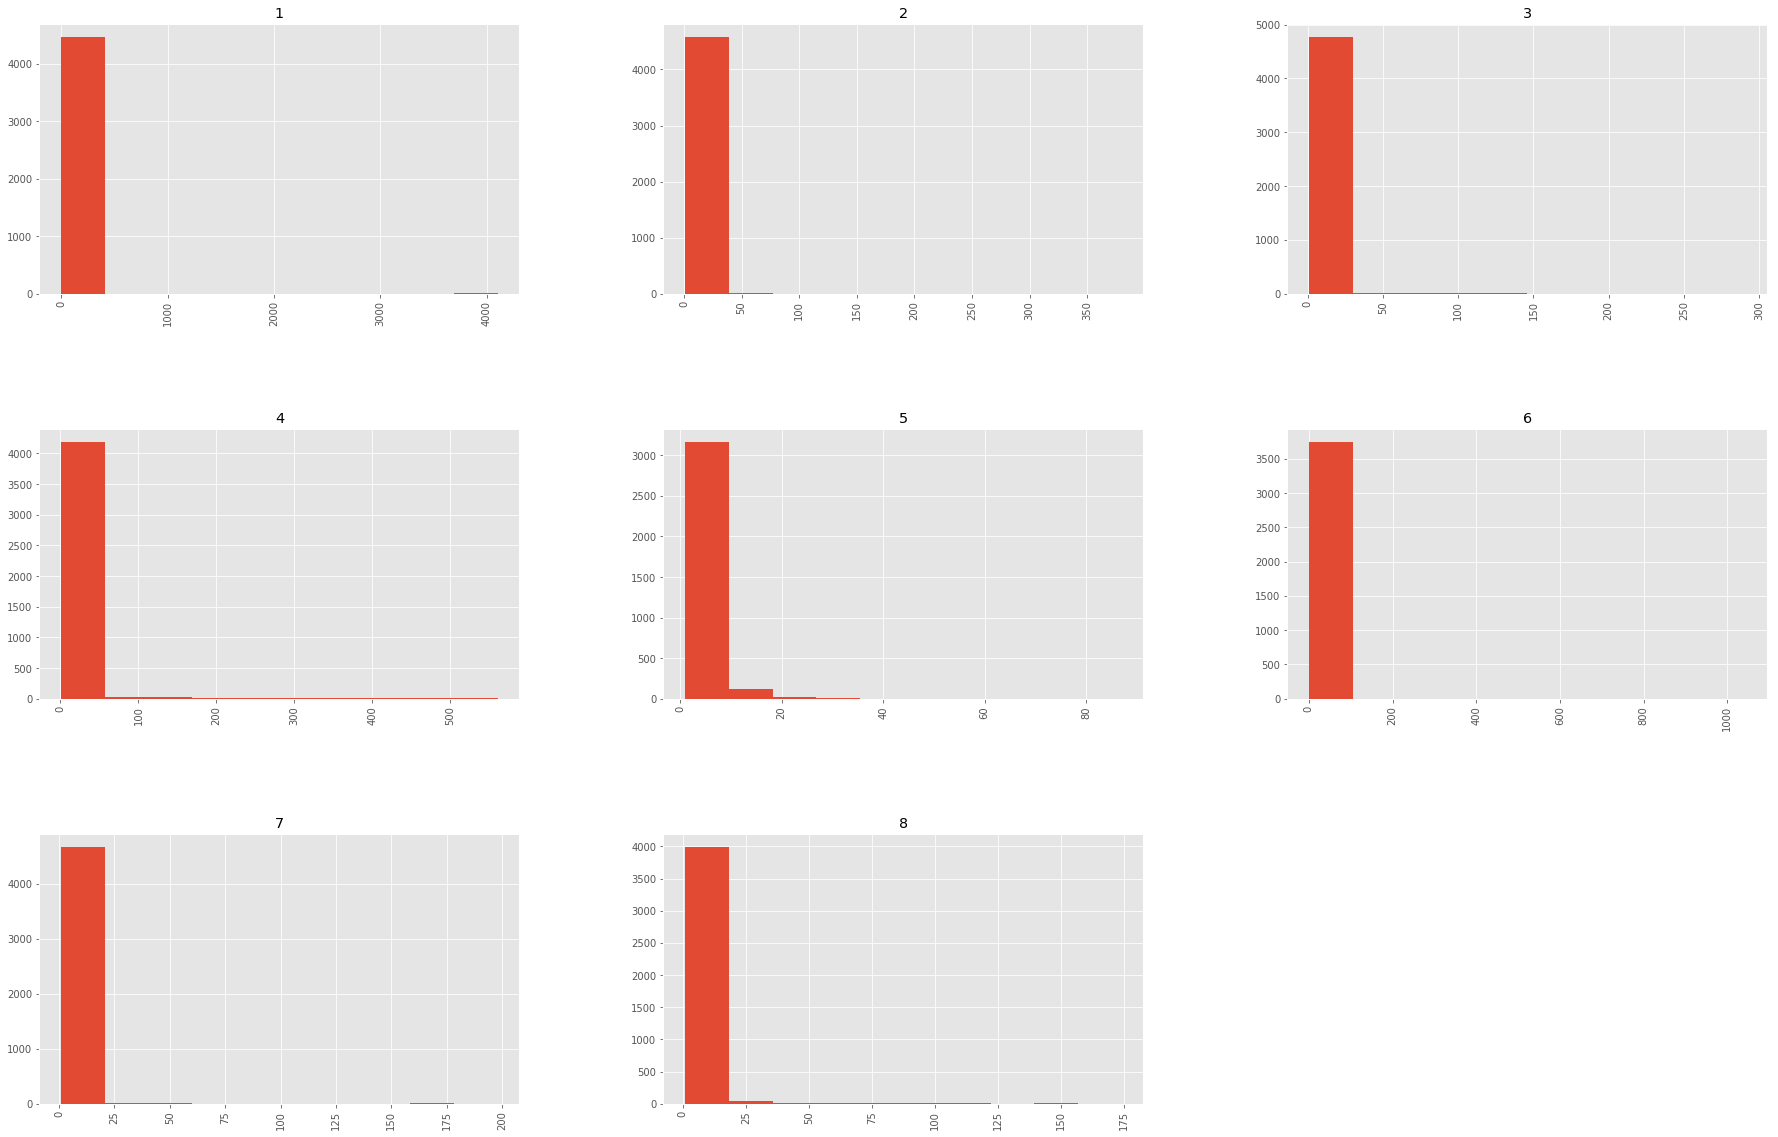

In [38]:
rp_vp['result_position'].hist(by=rp_vp['day'])
from pylab import rcParams
rcParams['figure.figsize'] = 30, 20
plt.show()

## "3. What is our daily overall zero results rate? How does it vary between the groups?"

The zero results rate is defined as "the proportion of searches that yielded 0 results."

In [26]:
# sort by session id and n_results 
num_results=df2.groupby(['session_id','n_results']).size().reset_index(name='count')
num_results.sort_values(by='session_id')[1:10]

,session_id,n_results,count
1,0001382e027b2ea4,18.0,1
2,0001e8bb90445cb2,20.0,1
3,000216cf18ae1ab1,20.0,6
4,000527f711d50dfc,1.0,1
5,00064fe774048046,0.0,1
6,00064fe774048046,1.0,1
7,00071a2cf97168df,20.0,1
8,0007582fe23d51e6,0.0,1
9,0007b7f6b575feb6,20.0,1


We see most sessions only have one search. Session '00064fe774048046' had two searches (likely because the first returned 0 results). 

In [27]:
num_searches=len(num_results)

There were {{num_searches}} total searches in this dataset. 

In [28]:
# which search returned 0 results
num_results['n_results']==0
zero_results=sum(num_results['n_results']==0)
zrr=zero_results/num_searches

We had {{zero_results}} searches with no results. Since we had {{num_searches}} in total, the zero results rate comes out to {{print("%.3f" % zrr)}}. 

Let's break down by group.

In [29]:
# A
num_results_a=group_a.groupby(['session_id','n_results']).size().reset_index(name='count')
# num_results_a.sort_values(by='session_id')[1:10]
num_searches_a=len(num_results_a)
num_results_a['n_results']==0
zero_results_a=sum(num_results_a['n_results']==0)
zrr_a=zero_results_a/num_searches_a
print(zrr_a)

# B
num_results_b=group_b.groupby(['session_id','n_results']).size().reset_index(name='count')
# num_results_b.sort_values(by='session_id')[1:10]
num_searches_b=len(num_results_b)
num_results_b['n_results']==0
zero_results_b=sum(num_results_b['n_results']==0)
zrr_b=zero_results_b/num_searches_b
print(zrr_b)

0.154193883778
0.182874195378


There isn't a huge difference between Groups A and B in the zero results rate ({{print("%.3f" %zrr_a)}} and {{print("%.3f" %zrr_b)}}) respectively.

In [30]:
from scipy import stats

a_no_results=num_results_a['n_results']==0
b_no_results=num_results_b['n_results']==0

stats.ttest_ind(a_no_results,b_no_results)

Ttest_indResult(statistic=-11.168759989874337, pvalue=6.0748755745501593e-29)

The p value on the t statistic returns {{print("%.3E" % stats.ttest_ind(a_no_results,b_no_results)[1])}}...so though the difference may not be important in practice, there is huge statistical significance. 

## "4. Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship."

In [31]:
# group by session and then find max and min timestamp in each session
starts=df.groupby(['session_id','weekday'], sort=False)['timestamp'].min().reset_index(name='start_time')
ends=df.groupby(['session_id','weekday'], sort=False)['timestamp'].max().reset_index(name='end_time')

In [32]:
# subtract first time from last time recorded in session to get approximate session time length
sess_time=ends['end_time']-starts['start_time']

In [33]:
# add session time to starts df for further analysis
starts['sess_time']=sess_time
starts['sess_time'].mean()

Timedelta('0 days 00:02:19.185080')

The average session is {{starts['sess_time'].mean()}} long. Now, let's see how average session time varies by day of week.

In [34]:
starts.head()

,session_id,weekday,start_time,sess_time
0,0000cbcb67c19c45,3,2016-03-03 15:20:45,00:00:00
1,0001382e027b2ea4,0,2016-03-07 08:49:55,00:05:03
2,0001e8bb90445cb2,5,2016-03-05 09:24:15,00:07:15
3,000216cf18ae1ab1,1,2016-03-08 16:19:46,00:00:58
4,000527f711d50dfc,1,2016-03-08 05:33:00,00:00:00


In [35]:
starts['integer_sess_time']=[starts['sess_time'][i].total_seconds() for i in range(len(starts))] # in seconds
starts.sort_values(by='integer_sess_time').head()

,session_id,weekday,start_time,sess_time,integer_sess_time
0,0000cbcb67c19c45,3,2016-03-03 15:20:45,0 days,0.0
35763,8631603f9841e99d,1,2016-03-08 14:57:38,0 days,0.0
35767,863639805e0bfc91,2,2016-03-02 20:42:38,0 days,0.0
35769,863937b2ef07b251,1,2016-03-08 01:50:51,0 days,0.0
35773,863ddd288e201fd8,6,2016-03-06 22:33:44,0 days,0.0


In [36]:
sess_by_weekday=starts.groupby('weekday')['integer_sess_time'].mean().reset_index(name='avg_sess_seconds')

In [37]:

action_data = [
    go.Bar(
        x=sess_by_weekday.weekday, # x axis labels -- the index of action_vcs df
        y=sess_by_weekday['avg_sess_seconds']
    )
]

layout=go.Layout(title="Session length by day of week", xaxis={'title':'Action'}, yaxis={'title':'Average session length'})
figure=go.Figure(data=action_data,layout=layout)
py.iplot(figure)

People spend more time throughout the week per session, with time peaking on Wednesday. Why? Something to investigate further.

## "5. Summarize your findings in an executive summary."

In summary:

- We had an unequal balance in groups...more individuals in group A than group B.
- CTR group A was ~.7 versus .2 for group B
- People are clicking on result 1 most often, with the most aberrational performance on Mondays.
- Zero results rate is around 17%.
- Longest sessions occur on Wednesday, a slight increase in session use from Sunday - Wednesday and then a dropoff thereafter. 

Hope you enjoyed reading. I enjoyed doing! I learned a lot about pandas groupby functionality, as well as awesome interaction plotly graphics. Fun fun. 